# v1 -> v2
- Uses self-created library for preprocessing
- Fixes many preprocessing errors
    - Now scales train/test sets properly (split->scale->concat instead of scale->concat->split)
          - slightly raises rmse
    - Removed custom mse function
          - significantly raises rmse
- Adds new experiments 🎉

# Test 0: HRRR + AirNow predicting stations

## HRRR preprocessing

In [1]:
# define bounding box
lat_bottom, lat_top = 33.6, 34.3
lon_bottom, lon_top = -118.6, -117.9
extent = (lon_bottom, lon_top, lat_bottom, lat_top)

# input data shape
dim = 40
frames_per_sample = 5

# date range of data
start_date, end_date = "2025-01-10-00", "2025-01-17-00"

In [2]:
from libs.hrrrdata import HRRRData
HD = HRRRData(
    start_date=start_date,
    end_date=end_date,
    extent=extent,
    product='MASSDEN',
    frames_per_sample=frames_per_sample,
    dim=dim,
    verbose=True
)

▌▌Herbie HRRR model sfc product initialized 2025-Jan-10 00:00 UTC F00 ┊ source=aws
▌▌Herbie HRRR model sfc product initialized 2025-Jan-10 01:00 UTC F00 ┊ source=aws
▌▌Herbie HRRR model sfc product initialized 2025-Jan-10 02:00 UTC F00 ┊ source=aws
▌▌Herbie HRRR model sfc product initialized 2025-Jan-10 03:00 UTC F00 ┊ source=aws
▌▌Herbie HRRR model sfc product initialized 2025-Jan-10 04:00 UTC F00 ┊ source=aws
▌▌Herbie HRRR model sfc product initialized 2025-Jan-10 05:00 UTC F00 ┊ source=aws
▌▌Herbie HRRR model sfc product initialized 2025-Jan-10 06:00 UTC F00 ┊ source=aws
▌▌Herbie HRRR model sfc product initialized 2025-Jan-10 07:00 UTC F00 ┊ source=aws
▌▌Herbie HRRR model sfc product initialized 2025-Jan-10 08:00 UTC F00 ┊ source=aws
▌▌Herbie HRRR model sfc product initialized 2025-Jan-10 09:00 UTC F00 ┊ source=aws
▌▌Herbie HRRR model sfc product initialized 2025-Jan-10 10:00 UTC F00 ┊ source=aws
▌▌Herbie HRRR model sfc product initialized 2025-Jan-10 11:00 UTC F00 ┊ source=aws
▌▌He

Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_d9ef9dd4__hrrr.t00z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_87ef9dd4__hrrr.t01z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_03ef9dd4__hrrr.t02z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_64ef9dd4__hrrr.t03z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_10ef9dd4__hrrr.t04z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_47ef9dd4__hrrr.t05z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_6def9dd4__hrrr.t06z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/

In [3]:
X_hrrr = HD.data
print(X_hrrr.shape)

(164, 5, 40, 40, 1)


## AirNow preprocessing

In [4]:
from libs.airnowdata import AirNowData
AD = AirNowData(
    start_date=start_date,
    end_date=end_date,
    extent=extent,
    airnow_api_key=None,
    save_dir='data/airnow.json',
    frames_per_sample=frames_per_sample,
    dim=dim
)

'data/airnow.json' already exists; skipping request...


In [5]:
X_airnow = AD.data
Y = AD.target_stations
print(X_airnow.shape)
print(Y.shape)

(164, 5, 40, 40, 1)
(164, 6)


## Joint preprocessing
- Split into train/test sets
- Scale train/test sets independently
- Combine X datasets into 1 with 2 channels

In [6]:
# split data
def train_test_split(X, train_size=0.75):
    split_idx = int(X.shape[0] * train_size)
    X_train, X_test = X[:split_idx], X[split_idx:]
    
    return X_train, X_test

# scale training data, then scale test data based on training data stats
from sklearn.preprocessing import StandardScaler
def std_scale(X_train, X_test):
    scaler = StandardScaler()
    scaled_train = scaler.fit_transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
    scaled_test = scaler.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)

    return scaled_train, scaled_test

In [7]:
import numpy as np

# split data
X_hrrr_train, X_hrrr_test = train_test_split(X_hrrr, train_size=0.75)
X_airnow_train, X_airnow_test = train_test_split(X_airnow, train_size=0.75)
y_train, y_test = train_test_split(Y, train_size=0.75)

# scale training data, then test data based on training data's stats
X_hrrr_train, X_hrrr_test = std_scale(X_hrrr_train, X_hrrr_test)
X_airnow_train, X_airnow_test = std_scale(X_airnow_train, X_airnow_test)

# combine each data source into one tensor, by channel
X_train = np.concatenate([X_hrrr_train, X_airnow_train], axis=-1)
X_test = np.concatenate([X_hrrr_test, X_airnow_test], axis=-1)

print("HRRR and AirNow, combined by channel:")
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

HRRR and AirNow, combined by channel:
(123, 5, 40, 40, 2) (41, 5, 40, 40, 2)
(123, 6) (41, 6)


## Final input viz

Displaying frames for example 102.


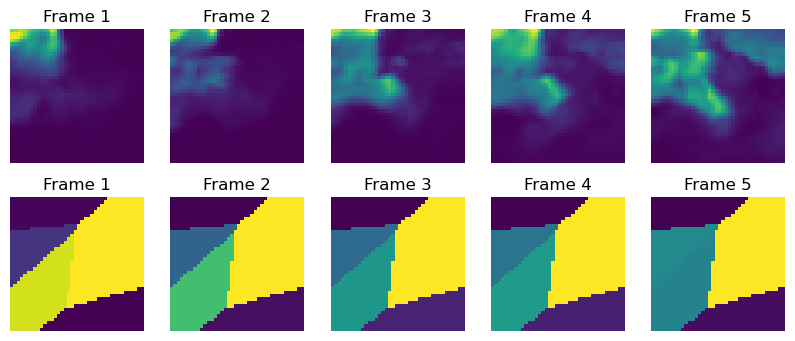

Target:  [ 2.  11.1 11.2 19.7  0.   4.8]


In [8]:
import matplotlib.pyplot as plt

# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

# Plot each of the sequential images for one random data example.
# plot hrrr channel
np.random.seed(42)
rand_sample = np.random.choice(range(len(X_train)), size=1)[0]
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(X_train[rand_sample, idx, :, :, 0]))
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")
# plot airnow channel
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(X_train[rand_sample, idx, :, :, 1]))
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {rand_sample}.")
plt.show()

print("Target: ", y_train[rand_sample])

## Model

In [9]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv3D
from keras.layers import ConvLSTM2D
from keras.layers import BatchNormalization
from keras.layers import Convolution2D, MaxPooling3D, Flatten, Reshape
from keras.layers import TimeDistributed
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import InputLayer

2025-04-10 22:02:28.402484: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-10 22:02:28.410473: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744347748.421102   29817 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744347748.424503   29817 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-10 22:02:28.434753: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [10]:
tf.keras.backend.set_image_data_format('channels_last')

seq = Sequential()

seq.add(
    InputLayer(shape=(5, 40, 40, 2))
)

seq.add(
    ConvLSTM2D(
            filters=15, 
            kernel_size=(3, 3),
            padding='same', 
            return_sequences=True
    )
)

seq.add(
    ConvLSTM2D(
        filters=30, 
        kernel_size=(3, 3),
        padding='same', 
        return_sequences=True
    )
)

seq.add(
    Conv3D(
        filters=15, 
        kernel_size=(3, 3, 3),
        activation='relu',
        padding='same'    
    )
)

seq.add(
    Conv3D(
        filters=1, 
        kernel_size=(3, 3, 3),
        activation='relu',
        padding='same'
    )
)

seq.add(Flatten())

seq.add(Dense(6,activation='relu'))

seq.compile(loss='mean_absolute_error', optimizer='adam')
seq.summary()

I0000 00:00:1744347749.691119   29817 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6402 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 5, 40, 40, 15)  │         9,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 5, 40, 40, 30)  │        48,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 5, 40, 40, 15)  │        12,165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 5, 40, 40, 1)   │           406 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │        48,006 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,537 (463.04 KB)

 Trainable params: 118,537 (463.04 KB)

 Non-trainable params: 0 (0.00 B)

## Train and test

In [11]:
seq.fit(X_train, y_train, batch_size=16, epochs=150)

Epoch 1/150


I0000 00:00:1744347752.066201   32852 service.cc:148] XLA service 0x71cbd000baa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744347752.066218   32852 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2025-04-10 22:02:32.119741: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744347752.386502   32852 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-04-10 22:02:32.757515: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[16,30,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,15,40,40]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}, f32[16,30,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backen

7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 12.7779

I0000 00:00:1744347754.404860   32852 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-04-10 22:02:35.072283: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[11,30,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[11,15,40,40]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}, f32[11,30,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":1},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-04-10 22:02:35.191404: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[11,15,40,40]{3,2,1,0}, u8[0]{0}

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 317ms/step - loss: 12.5453
Epoch 2/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 8.6689
Epoch 3/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 7.7767
Epoch 4/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 8.2050
Epoch 5/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 7.6682
Epoch 6/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 7.3966
Epoch 7/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.9780
Epoch 8/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.9660
Epoch 9/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.5877
Epoch 10/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.3918
Epoch 11/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.3390
Epoch 12/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5.8479
Epoch 13/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5.6214
Epoch 14/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5.7387
Epoch 15/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5.8759
Epoch 16/150
8/8 ━━━━━━━━━━━━

In [12]:
y_pred = seq.predict(X_test, verbose=0)
print(y_test.shape, y_pred.shape)

2025-04-10 22:03:11.458644: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,15,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,2,40,40]{3,2,1,0}, f32[15,2,3,3]{3,2,1,0}, f32[15]{0}, f32[32,15,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":1},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-04-10 22:03:11.509769: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,30,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,15,40,40]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}, f32[32,30,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01-

(41, 6) (41, 6)


In [13]:
from skimage.metrics import mean_squared_error as mse

def rmse(y_pred, y_test):
    return np.sqrt(mse(y_pred, y_test))

def nrmse(y_pred, y_test):
    return rmse(y_pred, y_test) / np.mean(y_test) * 100
    
print("Input: Interpolated Previous PM2.5 Sensor data + HRRR-smoke data")
print("Output: Future PM 2.5 Sensor data at 6 Locations in LA County Hourly (Using 5 previous frames to predict 5 future frames) \n")

print("RESULTS")
print("---------------------------------------------------------------------------")
print(f"All Days All Locations - y_pred vs y_test Raw RMSE: {rmse(y_pred, y_test):.2f}")
print(f"All Days All Locations - y_pred vs y_test RMSE Percent Error of Mean: {nrmse(y_pred, y_test):.2f}%\n")

print("RESULTS BY FRAME")
print("---------------------------------------------------------------------------")
for i in range(5):
    print(f"Frame {i+1} (Hour {i+1}) All Locations - Raw RMSE: {rmse(y_pred[i,:], y_test[i,:]):.2f}")
    print(f"Frame {i+1} (Hour {i+1}) All Locations - RMSE Percent Error of Mean: {nrmse(y_pred[i,:], y_test[i,:]):.2f}%\n")

print("RESULTS BY SENSOR LOCATION")
print("---------------------------------------------------------------------------")
for i, loc in enumerate(list(AD.air_sens_loc.keys())):
    print(f"All Days - {loc} Raw RMSE: {rmse(y_pred[:,i], y_test[:,i]):.2f}")
    print(f"All Days - {loc} RMSE Percent Error of Mean: {nrmse(y_pred[:,i], y_test[:,i]):.2f}%\n")

Input: Interpolated Previous PM2.5 Sensor data + HRRR-smoke data
Output: Future PM 2.5 Sensor data at 6 Locations in LA County Hourly (Using 5 previous frames to predict 5 future frames) 

RESULTS
---------------------------------------------------------------------------
All Days All Locations - y_pred vs y_test Raw RMSE: 5.11
All Days All Locations - y_pred vs y_test RMSE Percent Error of Mean: 52.96%

RESULTS BY FRAME
---------------------------------------------------------------------------
Frame 1 (Hour 1) All Locations - Raw RMSE: 3.81
Frame 1 (Hour 1) All Locations - RMSE Percent Error of Mean: 31.66%

Frame 2 (Hour 2) All Locations - Raw RMSE: 3.82
Frame 2 (Hour 2) All Locations - RMSE Percent Error of Mean: 32.95%

Frame 3 (Hour 3) All Locations - Raw RMSE: 4.96
Frame 3 (Hour 3) All Locations - RMSE Percent Error of Mean: 40.81%

Frame 4 (Hour 4) All Locations - Raw RMSE: 5.34
Frame 4 (Hour 4) All Locations - RMSE Percent Error of Mean: 43.12%

Frame 5 (Hour 5) All Locations 

## RMSE results visualization


Visualizing model predictions vs actual values...


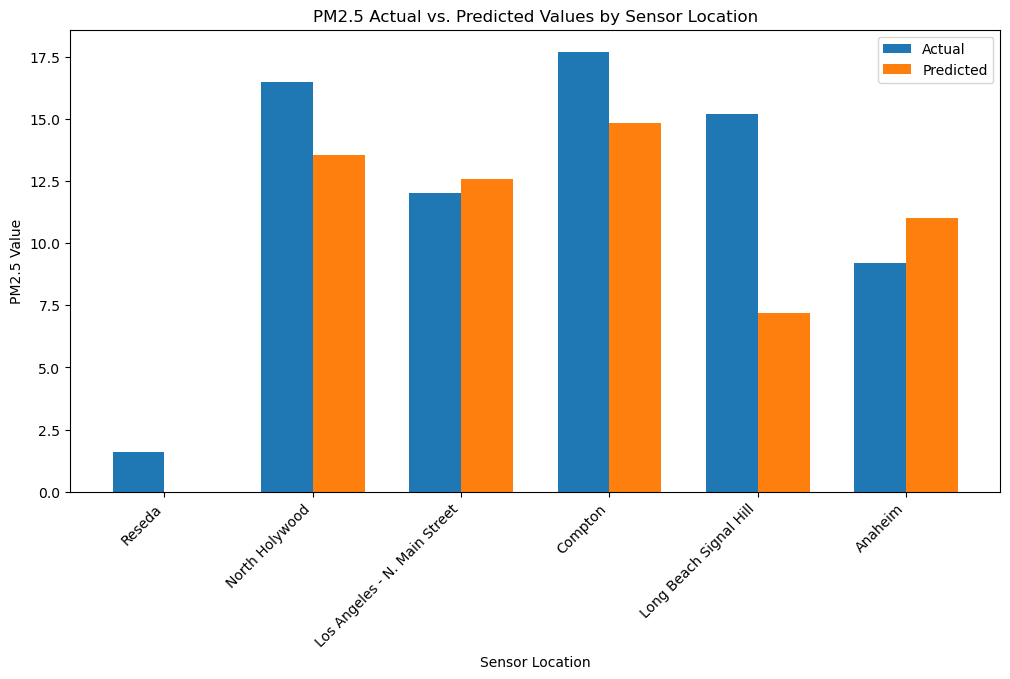

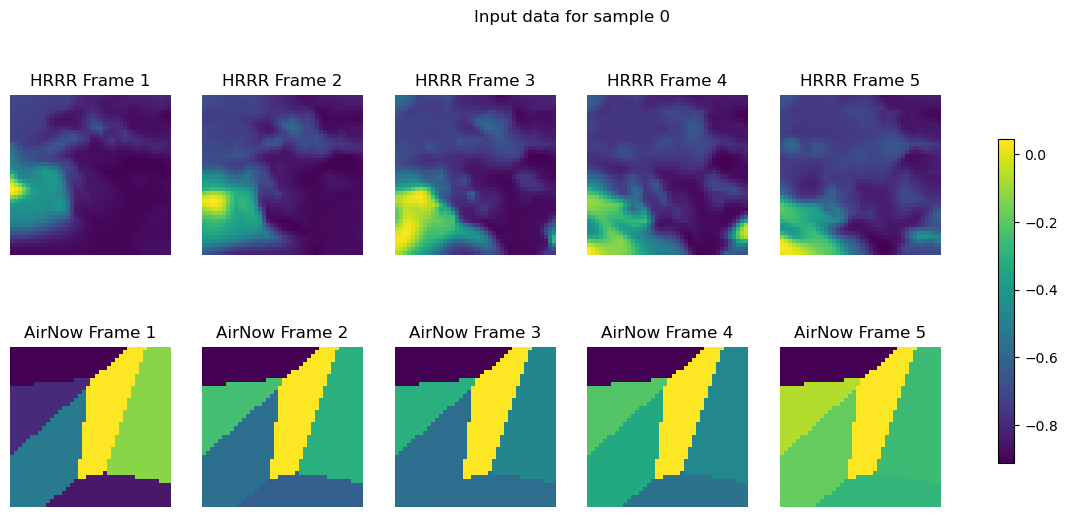

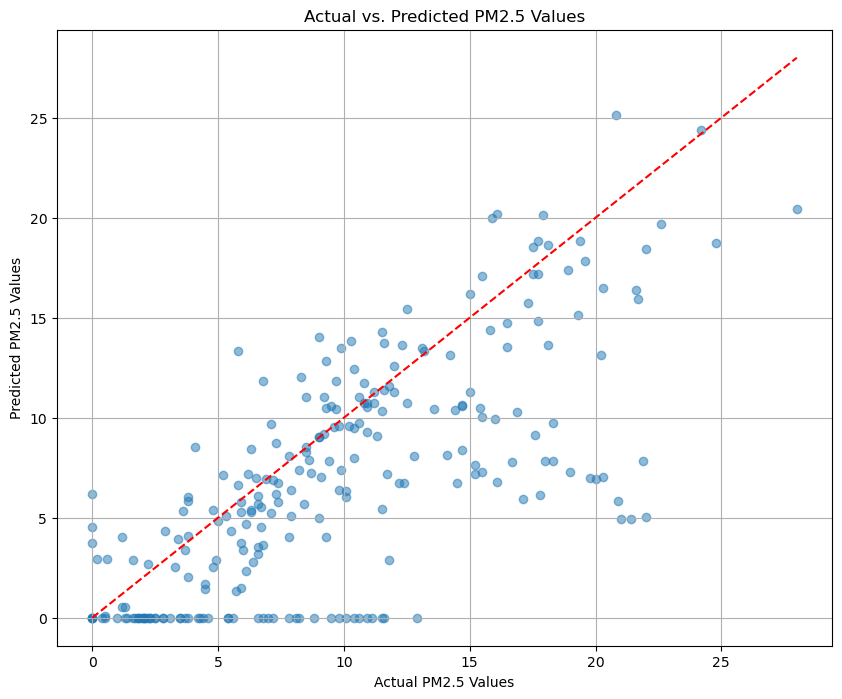

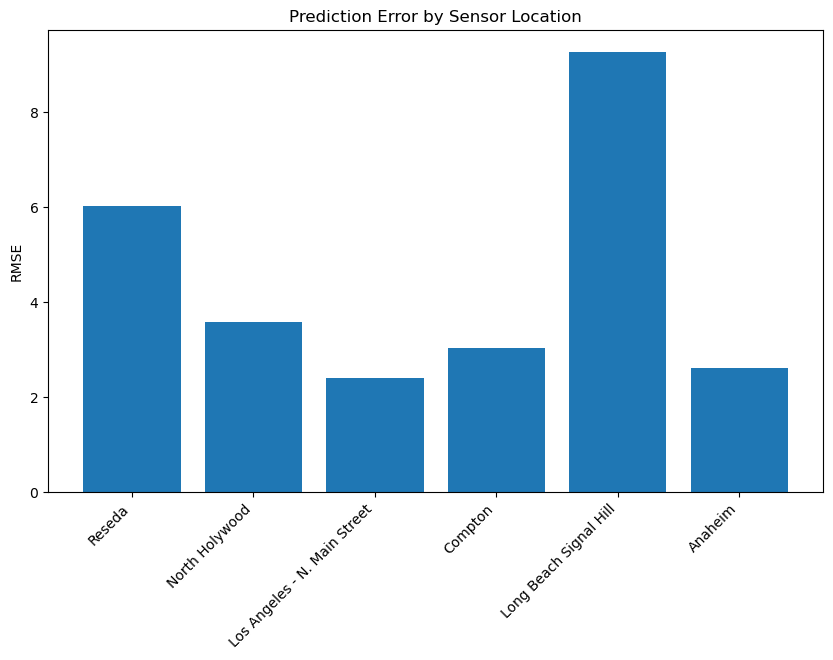

In [14]:
print("\nVisualizing model predictions vs actual values...")

# Choose the first test sample for consistent visualizations
sample_idx = 0

# Create a bar chart comparing predicted vs actual values for each sensor
fig, ax = plt.subplots(figsize=(12, 6))
sensor_names = list(AD.air_sens_loc.keys())
x = np.arange(len(sensor_names))
width = 0.35

true_vals = y_test[sample_idx]
pred_vals = y_pred[sample_idx]

rects1 = ax.bar(x - width/2, true_vals, width, label='Actual')
rects2 = ax.bar(x + width/2, pred_vals, width, label='Predicted')

ax.set_title('PM2.5 Actual vs. Predicted Values by Sensor Location')
ax.set_ylabel('PM2.5 Value')
ax.set_xlabel('Sensor Location')
ax.set_xticks(x)
ax.set_xticklabels(sensor_names, rotation=45, ha='right')
ax.legend()

#plt.tight_layout()
plt.show()

# Visualize input data for a specific sample
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Plot hrrr data (channel 0)
for idx, ax in enumerate(axes[0]):
    im = ax.imshow(np.squeeze(X_test[sample_idx, idx, :, :, 0]), cmap='viridis')
    ax.set_title(f"HRRR Frame {idx + 1}")
    ax.axis("off")

# Plot AirNow data (channel 1)
for idx, ax in enumerate(axes[1]):
    im = ax.imshow(np.squeeze(X_test[sample_idx, idx, :, :, 1]), cmap='viridis')
    ax.set_title(f"AirNow Frame {idx + 1}")
    ax.axis("off")

plt.colorbar(im, ax=axes.ravel().tolist(), shrink=0.7)
plt.suptitle(f'Input data for sample {sample_idx}')
#plt.tight_layout()
plt.show()

# Create a scatter plot of predicted vs actual values
plt.figure(figsize=(10, 8))
plt.scatter(y_test.flatten(), y_pred.flatten(), alpha=0.5)
plt.plot([0, np.max(y_test)], [0, np.max(y_test)], 'r--')  # Perfect prediction line
plt.xlabel('Actual PM2.5 Values')
plt.ylabel('Predicted PM2.5 Values')
plt.title('Actual vs. Predicted PM2.5 Values')
plt.grid(True)
#plt.tight_layout()
plt.show()

# Compute error metrics for each sensor
error_by_sensor = []
for i, sensor in enumerate(sensor_names):
    error = rmse(y_pred[:, i], y_test[:, i])
    error_by_sensor.append(error)

# Create bar chart of errors by sensor
plt.figure(figsize=(10, 6))
plt.bar(sensor_names, error_by_sensor)
plt.ylabel('RMSE')
plt.title('Prediction Error by Sensor Location')
plt.xticks(rotation=45, ha='right')
#plt.tight_layout()
plt.show()

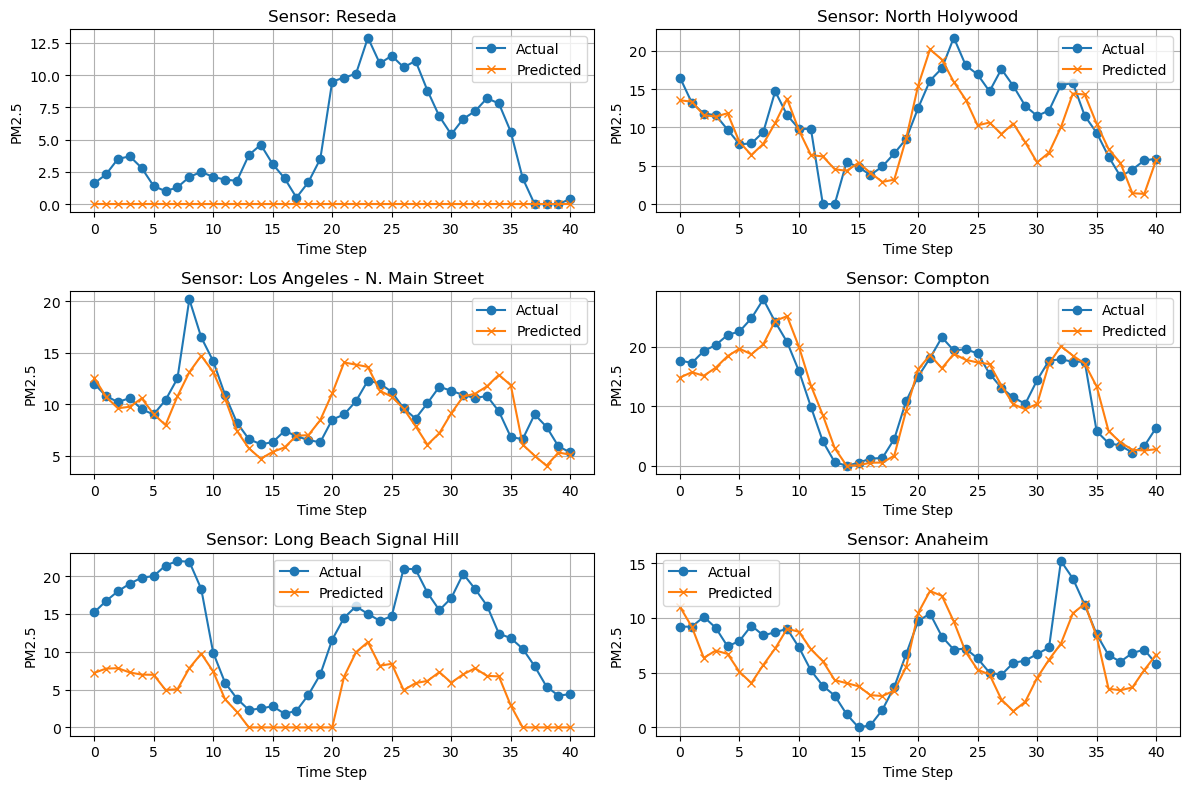

In [15]:
plt.figure(figsize=(12, 8))
for i, sensor in enumerate(AD.air_sens_loc.keys()):
    plt.subplot(3, 2, i + 1)
    plt.plot(y_test[:, i], label='Actual', marker='o')
    plt.plot(y_pred[:, i], label='Predicted', marker='x')
    plt.title(f'Sensor: {sensor}')
    plt.xlabel('Time Step')
    plt.ylabel('PM2.5')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

## Looking into Reseda data

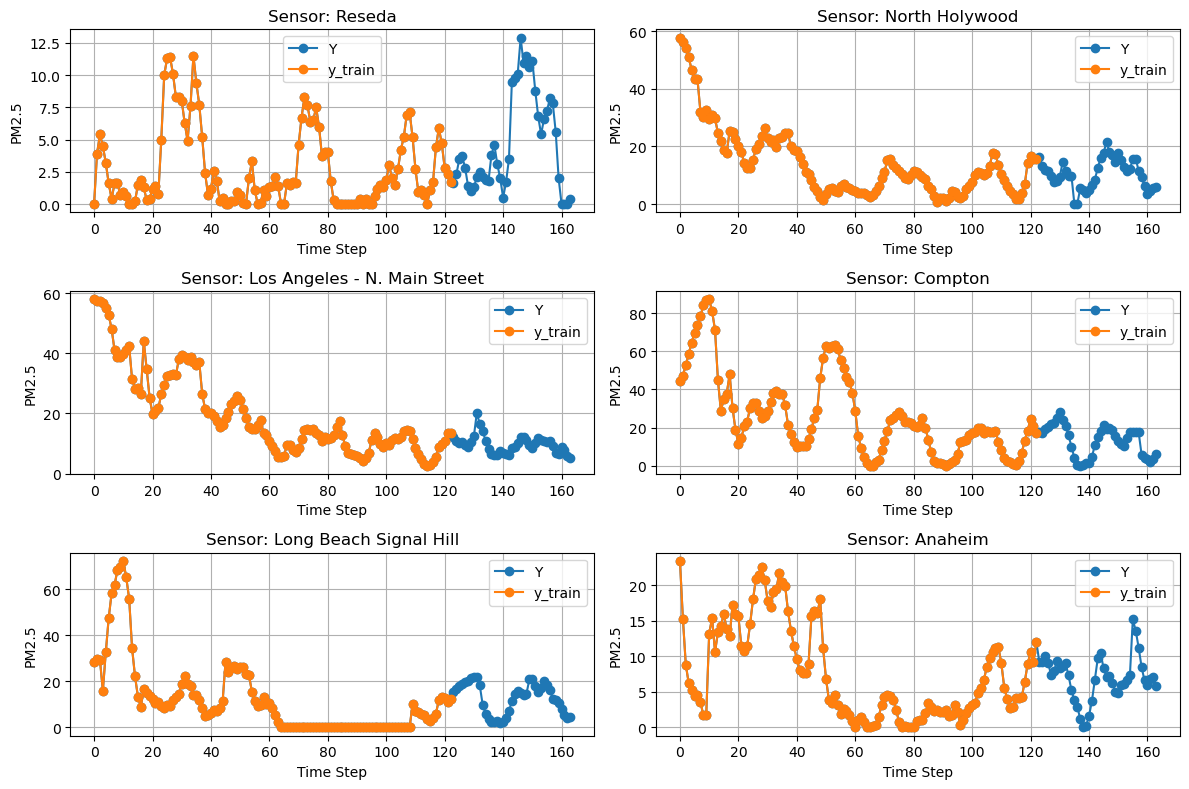

In [16]:
plt.figure(figsize=(12, 8))
for i, sensor in enumerate(AD.air_sens_loc.keys()):
    plt.subplot(3, 2, i + 1)
    plt.plot(Y[:, i], label='Y', marker='o')
    plt.plot(y_train[:, i], label='y_train', marker='o')
    plt.title(f'Sensor: {sensor}')
    plt.xlabel('Time Step')
    plt.ylabel('PM2.5')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

While the Reseda data has a different shape to it than the rest of the data, I don't see why the model would predict only zeros for it.

In [17]:
print(y_pred[:, 0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Yup, all the predictions are 0

In [18]:
print(y_train[:, 0])
print(y_test[:, 0])
x, y = AD.air_sens_loc['Reseda']
grids = np.array(AD.ground_site_grids)
grids[5:, x, y]

[ 0.   3.9  5.4  4.5  3.2  1.6  0.4  1.6  1.6  0.7  0.9  0.6  0.   0.
  0.2  1.5  1.9  1.3  0.3  0.4  1.2  1.4  0.8  5.  10.  11.3 11.4 10.1
  8.3  8.3  8.   6.3  4.9  7.6 11.5  9.4  7.7  5.2  2.4  0.7  1.2  2.6
  1.8  0.2  0.5  0.   0.   0.2  0.2  0.9  0.7  0.1  0.   2.   3.3  1.1
  0.   0.1  1.1  0.6  1.3  1.4  2.1  1.4  0.   0.   1.6  1.5  1.7  1.6
  4.6  6.7  8.3  7.7  6.4  6.5  7.5  6.   3.7  4.   4.   1.8  0.3  0.
  0.   0.   0.   0.   0.   0.   0.   0.4  0.   0.4  0.   0.   0.6  1.2
  1.5  1.3  1.9  3.   2.   1.5  2.7  4.2  5.2  6.9  7.1  5.2  2.7  0.9
  1.1  0.7  0.   1.1  1.7  4.4  5.9  4.7  2.8  2.3  1.7]
[ 1.6  2.3  3.5  3.7  2.8  1.4  1.   1.3  2.1  2.5  2.1  1.9  1.8  3.8
  4.6  3.1  2.   0.5  1.7  3.5  9.5  9.8 10.1 12.9 10.9 11.5 10.6 11.1
  8.8  6.8  5.4  6.6  7.2  8.2  7.8  5.6  2.   0.   0.   0.   0.4]


array([ 0. ,  3.9,  5.4,  4.5,  3.2,  1.6,  0.4,  1.6,  1.6,  0.7,  0.9,
        0.6,  0. ,  0. ,  0.2,  1.5,  1.9,  1.3,  0.3,  0.4,  1.2,  1.4,
        0.8,  5. , 10. , 11.3, 11.4, 10.1,  8.3,  8.3,  8. ,  6.3,  4.9,
        7.6, 11.5,  9.4,  7.7,  5.2,  2.4,  0.7,  1.2,  2.6,  1.8,  0.2,
        0.5,  0. ,  0. ,  0.2,  0.2,  0.9,  0.7,  0.1,  0. ,  2. ,  3.3,
        1.1,  0. ,  0.1,  1.1,  0.6,  1.3,  1.4,  2.1,  1.4,  0. ,  0. ,
        1.6,  1.5,  1.7,  1.6,  4.6,  6.7,  8.3,  7.7,  6.4,  6.5,  7.5,
        6. ,  3.7,  4. ,  4. ,  1.8,  0.3,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0.4,  0. ,  0.4,  0. ,  0. ,  0.6,  1.2,  1.5,
        1.3,  1.9,  3. ,  2. ,  1.5,  2.7,  4.2,  5.2,  6.9,  7.1,  5.2,
        2.7,  0.9,  1.1,  0.7,  0. ,  1.1,  1.7,  4.4,  5.9,  4.7,  2.8,
        2.3,  1.7,  1.6,  2.3,  3.5,  3.7,  2.8,  1.4,  1. ,  1.3,  2.1,
        2.5,  2.1,  1.9,  1.8,  3.8,  4.6,  3.1,  2. ,  0.5,  1.7,  3.5,
        9.5,  9.8, 10.1, 12.9, 10.9, 11.5, 10.6, 11

Doesn't seem like there's an issue with the interpolated grid data?

# Test 1: How much does HRRR matter, really?
We'll train a model with AirNow data only. All the preprocessing should already be done for us.

## Model

In [19]:
print(X_airnow_train.shape, X_airnow_test.shape, y_train.shape, y_test.shape)

(123, 5, 40, 40, 1) (41, 5, 40, 40, 1) (123, 6) (41, 6)


In [20]:
tf.keras.backend.set_image_data_format('channels_last')

seq = Sequential()

seq.add(
    InputLayer(shape=(5, 40, 40, 1))
)

seq.add(
    ConvLSTM2D(
            filters=15, 
            kernel_size=(3, 3),
            padding='same', 
            return_sequences=True
    )
)

seq.add(
    ConvLSTM2D(
        filters=30, 
        kernel_size=(3, 3),
        padding='same', 
        return_sequences=True
    )
)

seq.add(
    Conv3D(
        filters=15, 
        kernel_size=(3, 3, 3),
        activation='relu',
        padding='same'    
    )
)

seq.add(
    Conv3D(
        filters=1, 
        kernel_size=(3, 3, 3),
        activation='relu',
        padding='same'
    )
)

seq.add(Flatten())

seq.add(Dense(6,activation='relu'))

seq.compile(loss='mean_absolute_error', optimizer='adam')
seq.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d_2 (ConvLSTM2D)      │ (None, 5, 40, 40, 15)  │         8,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)      │ (None, 5, 40, 40, 30)  │        48,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 5, 40, 40, 15)  │        12,165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 5, 40, 40, 1)   │           406 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │        48,006 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,997 (460.93 KB)

 Trainable params: 117,997 (460.93 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
seq.fit(X_airnow_train, y_train, batch_size=16, epochs=150)

Epoch 1/150


2025-04-10 22:03:16.477651: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[16,15,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,1,40,40]{3,2,1,0}, f32[15,1,3,3]{3,2,1,0}, f32[15]{0}, f32[16,15,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":1},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}


7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 11.8331

2025-04-10 22:03:18.253706: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[11,15,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[11,1,40,40]{3,2,1,0}, f32[15,1,3,3]{3,2,1,0}, f32[15]{0}, f32[11,15,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":1},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 268ms/step - loss: 11.7360
Epoch 2/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 7.0282
Epoch 3/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 6.1565
Epoch 4/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5.7040
Epoch 5/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5.5082
Epoch 6/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5.7847
Epoch 7/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 5.6059
Epoch 8/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 5.5429
Epoch 9/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5.8014
Epoch 10/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5.9392
Epoch 11/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.8868
Epoch 12/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.9020
Epoch 13/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.9874
Epoch 14/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.8507
Epoch 15/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.6040
Epoch 16/150
8/8 ━━━━━━━━━━━━

## Results

In [22]:
y_pred = seq.predict(X_airnow_test, verbose=0)

2025-04-10 22:03:53.905220: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,15,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1,40,40]{3,2,1,0}, f32[15,1,3,3]{3,2,1,0}, f32[15]{0}, f32[32,15,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":1},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}


In [23]:
print("Input: Interpolated Previous PM2.5 Sensor data + HRRR-smoke data")
print("Output: Future PM 2.5 Sensor data at 6 Locations in LA County Hourly (Using 5 previous frames to predict 5 future frames) \n")

print("RESULTS")
print("---------------------------------------------------------------------------")
print(f"All Days All Locations - y_pred vs y_test Raw RMSE: {rmse(y_pred, y_test):.2f}")
print(f"All Days All Locations - y_pred vs y_test RMSE Percent Error of Mean: {nrmse(y_pred, y_test):.2f}%\n")

print("RESULTS BY FRAME")
print("---------------------------------------------------------------------------")
for i in range(5):
    print(f"Frame {i+1} (Hour {i+1}) All Locations - Raw RMSE: {rmse(y_pred[i,:], y_test[i,:]):.2f}")
    print(f"Frame {i+1} (Hour {i+1}) All Locations - RMSE Percent Error of Mean: {nrmse(y_pred[i,:], y_test[i,:]):.2f}%\n")

print("RESULTS BY SENSOR LOCATION")
print("---------------------------------------------------------------------------")
for i, loc in enumerate(list(AD.air_sens_loc.keys())):
    print(f"All Days - {loc} Raw RMSE: {rmse(y_pred[:,i], y_test[:,i]):.2f}")
    print(f"All Days - {loc} RMSE Percent Error of Mean: {nrmse(y_pred[:,i], y_test[:,i]):.2f}%\n")

Input: Interpolated Previous PM2.5 Sensor data + HRRR-smoke data
Output: Future PM 2.5 Sensor data at 6 Locations in LA County Hourly (Using 5 previous frames to predict 5 future frames) 

RESULTS
---------------------------------------------------------------------------
All Days All Locations - y_pred vs y_test Raw RMSE: 3.77
All Days All Locations - y_pred vs y_test RMSE Percent Error of Mean: 39.08%

RESULTS BY FRAME
---------------------------------------------------------------------------
Frame 1 (Hour 1) All Locations - Raw RMSE: 2.40
Frame 1 (Hour 1) All Locations - RMSE Percent Error of Mean: 19.95%

Frame 2 (Hour 2) All Locations - Raw RMSE: 2.01
Frame 2 (Hour 2) All Locations - RMSE Percent Error of Mean: 17.34%

Frame 3 (Hour 3) All Locations - Raw RMSE: 2.52
Frame 3 (Hour 3) All Locations - RMSE Percent Error of Mean: 20.78%

Frame 4 (Hour 4) All Locations - Raw RMSE: 2.48
Frame 4 (Hour 4) All Locations - RMSE Percent Error of Mean: 20.01%

Frame 5 (Hour 5) All Locations 

## Visualization

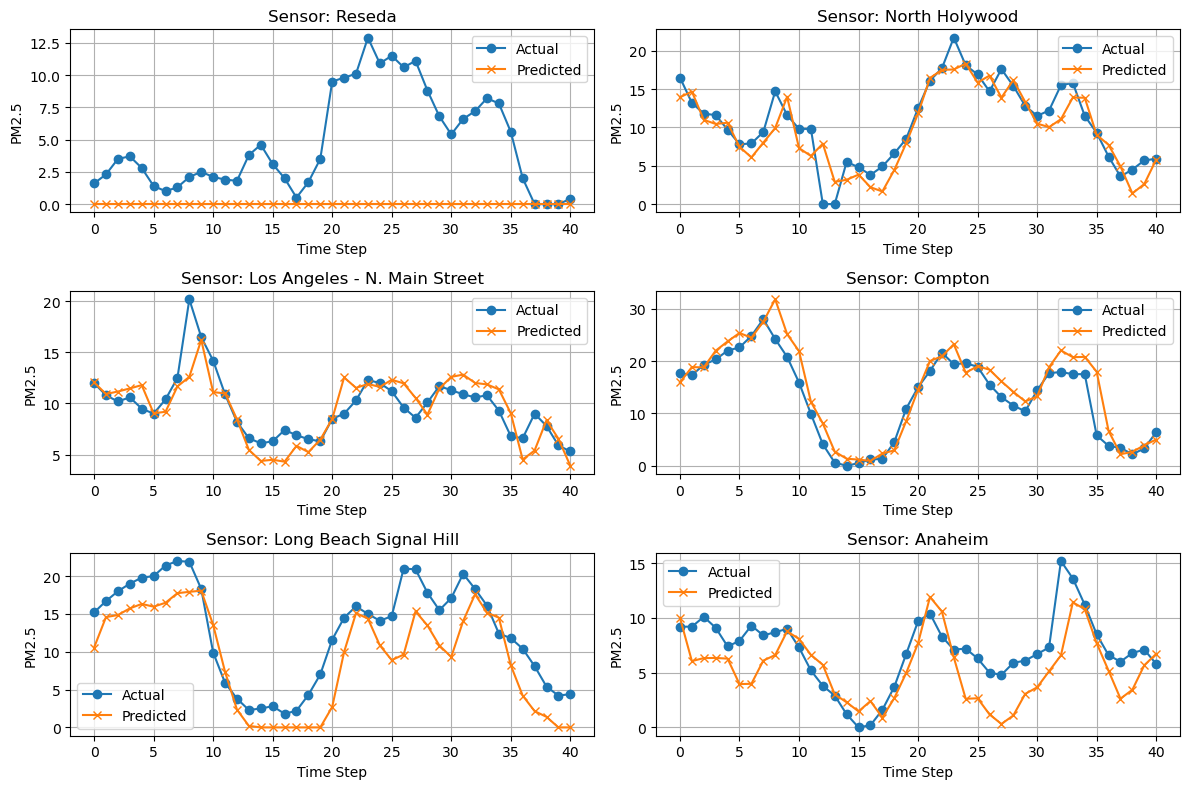

In [24]:
plt.figure(figsize=(12, 8))
for i, sensor in enumerate(AD.air_sens_loc.keys()):
    plt.subplot(3, 2, i + 1)
    plt.plot(y_test[:, i], label='Actual', marker='o')
    plt.plot(y_pred[:, i], label='Predicted', marker='x')
    plt.title(f'Sensor: {sensor}')
    plt.xlabel('Time Step')
    plt.ylabel('PM2.5')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

Ideas: Seems like HRRR is just noise. Also, what is going on with Reseda? The training data doesn't seem off?